In [1]:
import os
import json
import re
from collections import defaultdict, Counter
from tqdm import tqdm
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import defaultdict, Counter

In [2]:
SPLIT_PATTERN = re.compile(r'\s*[,/;]+\s*|\s+and\s+')

def parse_occupations(line):
    """Unified occupation parsing used by both functions"""
    occupations = set()
    tokens = line.split('\t')
    for token in tokens:
        if 'occupation_' in token:
            part = token.split(':', 1)[1].strip()
            part = part.replace('[[', '').replace(']]', '').replace('*', '').strip()
            if part:
                # Split using shared pattern and normalize
                split_parts = SPLIT_PATTERN.split(part)
                for p in split_parts:
                    clean = p.strip().lower()
                    if clean:
                        occupations.add(clean)
    return occupations
# ==========================================================

def count_occupations(dataset_dir):
    counter = Counter()
    subsets = ['train/train', 'valid/valid', 'test/test']
    
    for subset in subsets:
        box_file = os.path.join(dataset_dir, f"{subset}.box")
        with open(box_file, 'r', encoding='utf-8') as bfile:
            for line in tqdm(bfile, desc=f"Counting {subset}"):
                occupations = parse_occupations(line)
                counter.update(occupations)
    
    return counter

def get_groups(dataset_dir, target_occupations, char_threshold=50):
    groups = {occ: defaultdict(str) for occ in target_occupations}
    subsets = ['train/train', 'valid/valid', 'test/test']

    for subset in subsets:
        title_file = os.path.join(dataset_dir, f"{subset}.title")
        box_file = os.path.join(dataset_dir, f"{subset}.box")
        sent_file = os.path.join(dataset_dir, f"{subset}.sent")
        nb_file = os.path.join(dataset_dir, f"{subset}.nb")

        with open(title_file, 'r') as tfile, \
             open(box_file, 'r') as bfile, \
             open(sent_file, 'r') as sfile, \
             open(nb_file, 'r') as nfile:

            titles = [line.strip() for line in tfile]
            sents = [line.strip() for line in sfile]
            nb_counts = [int(line.strip()) for line in nfile]
            
            sent_ptr = 0
            for idx, (bline, num_sent) in enumerate(zip(bfile, nb_counts)):
                occupations = parse_occupations(bline)
                summary = ' '.join(sents[sent_ptr:sent_ptr + num_sent]).strip()
                name = titles[idx]
                
                if len(summary) >= char_threshold:
                    for occ in occupations & set(target_occupations):
                        groups[occ][name] = summary
                
                sent_ptr += num_sent

    return groups

In [3]:
dataset_dir = 'wikipedia-biography-dataset/wikipedia-biography-dataset'

# Get counts
counts = count_occupations(dataset_dir)
sorted_occupations = sorted(counts.items(), key=lambda x: (-x[1], x[0]))
top_ten = [occ for occ, _ in counts.most_common(10)]

Counting train/train: 3588it [00:00, 35872.85it/s]

Counting train/train: 582659it [00:05, 98916.15it/s] 
Counting valid/valid: 72831it [00:00, 83292.33it/s]
Counting test/test: 72831it [00:00, 93282.44it/s] 


In [4]:
with open('output/top_ten/occupation_counts_2.json', 'w', encoding='utf-8') as f:
    json.dump(sorted_occupations, f, ensure_ascii=False, indent=2)

In [5]:
top_ten = ["actor", "actress", "singer", "producer", "musician", "director", "writer", "songwriter", "politician", "author"]

In [6]:
# Get groups
groups = get_groups(dataset_dir, top_ten, char_threshold=50)

for o in groups:
    print(f"{o}: {len(groups[o])} biographies")

actor: 27071 biographies
actress: 19860 biographies
singer: 16337 biographies
producer: 15776 biographies
musician: 14879 biographies
director: 14402 biographies
writer: 14102 biographies
songwriter: 9870 biographies
politician: 8517 biographies
author: 8081 biographies


In [7]:
with open("output/top_ten/occupation_summaries.json", "w") as f:
    json.dump(groups, f, indent=2, ensure_ascii=False)

In [8]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/yc833/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yc833/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/yc833/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Initialize NLP tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
custom_stop_words = {'also', 'known', 'later', 'born', 'became', 'lxi', 'lx', '``', '-lrb-', '-rrb-',"'s",'--'} 
stop_words.update(custom_stop_words)
punctuation = set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

# def preprocess_text(text):
#     """Tokenize, lemmatize, and clean text"""
#     tokens = word_tokenize(text.lower())
#     cleaned = []
#     for token in tokens:
#         if token not in stop_words and token not in punctuation:
#             lemma = lemmatizer.lemmatize(token)
#             cleaned.append(lemma)
#     return cleaned

# def get_feature_probabilities(occupation_groups, top_n=50):
#     """Calculate P(f|occupation) for top features"""
#     feature_probs = defaultdict(dict)
#     pair_count = defaultdict(dict)
#     occ_count = defaultdict(int)
#     all_matrices = defaultdict(int)
    
#     for occupation, summaries in tqdm(occupation_groups.items(), desc="Processing occupations"):
#         # Collect all words across summaries
#         all_words = []
#         co_occurrence_counts = defaultdict(lambda: defaultdict(int))
#         feature_counts = defaultdict(int)

#         for summary in summaries.values():
#             all_words.extend(preprocess_text(summary))
            
#         word_counts = Counter(all_words)
#         top_features = [word for word, _ in word_counts.most_common(top_n)]

#         for word in top_features:
#             pair_count[occupation][word] = 0
#             for word2 in top_features:
#                 co_occurrence_counts[word][word2] = 0
        
#         for summary in summaries.values():
#             s = preprocess_text(summary)
#             occ_count[occupation] += 1
#             for word in top_features:
#                 # print(word)
#                 # print(s)
#                 if word in s:
#                     pair_count[occupation][word] += 1

#             features_in_summary = [word for word in s if word in top_features]
#             in_this_summary = set()
#             for i in range(len(features_in_summary)):
#                 for j in range(i + 1, len(features_in_summary)):
#                     if (features_in_summary[i],features_in_summary[j]) not in in_this_summary:
#                         in_this_summary.add((features_in_summary[i], features_in_summary[j]))
#                         feature_counts[features_in_summary[i]] += 1
#                         co_occurrence_counts[features_in_summary[i]][features_in_summary[j]] += 1      

#         matrix_size = len(top_features)
#         probability_matrix = np.zeros((matrix_size, matrix_size))
        
#         for i, f1 in enumerate(top_features):
#             total_co_occurrences = sum(co_occurrence_counts[f1].values())
#             for j, f2 in enumerate(top_features):
#                 # if f1 != f2 and total_co_occurrences > 0:
#                 if total_co_occurrences > 0:
#                     probability_matrix[i, j] = co_occurrence_counts[f1][f2] / total_co_occurrences  
        
#         all_matrices[occupation] = {'features': top_features, 'matrix': probability_matrix}

#         for word in top_features:
#             feature_probs[occupation][word] = pair_count[occupation][word] / occ_count[occupation]
    
#     return feature_probs, all_matrices


In [24]:
from utils import preprocess_text, get_feature_probabilities

[nltk_data] Downloading package stopwords to /home/yc833/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yc833/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yc833/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
# # get feature probabilities
# feature_probs = get_feature_probabilities(groups)
# # with open("output/top_ten/feature_probabilities.json", "w") as f:
# #     json.dump(feature_probs, f, indent=2, ensure_ascii=False)

In [26]:
# # both f_1|occ and matrices
# feature_probs, all_matrices = get_feature_probabilities(groups)
# with open("output/top_ten/feature_probabilities_2.json", "w") as f:
#     json.dump(feature_probs, f, indent=2, ensure_ascii=False)

In [27]:
import os
import json
from collections import defaultdict
import numpy as np

# Save feature probabilities (already JSON-serializable)
def save_feature_probs(feature_probs, output_path):
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(feature_probs, f, indent=2, ensure_ascii=False)

# Save all_matrices by converting NumPy arrays to lists
def save_all_matrices(all_matrices, output_path):
    all_matrices_serializable = {}
    for occ, mat_dict in all_matrices.items():
        all_matrices_serializable[occ] = {
            "features": mat_dict["features"],
            "matrix": mat_dict["matrix"].tolist()  # convert NumPy array to list
        }
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(all_matrices_serializable, f, indent=2, ensure_ascii=False)




In [28]:
feature_probs, all_matrices = get_feature_probabilities(groups)
save_feature_probs(feature_probs, "output/top_ten/feature_probabilities_wiki.json")
save_all_matrices(all_matrices, "output/top_ten/all_matrices_wiki.json")

Processing occupations: 100%|██████████| 10/10 [05:49<00:00, 34.96s/it]


In [29]:
feature_probs.keys()

dict_keys(['actor', 'actress', 'singer', 'producer', 'musician', 'director', 'writer', 'songwriter', 'politician', 'author'])

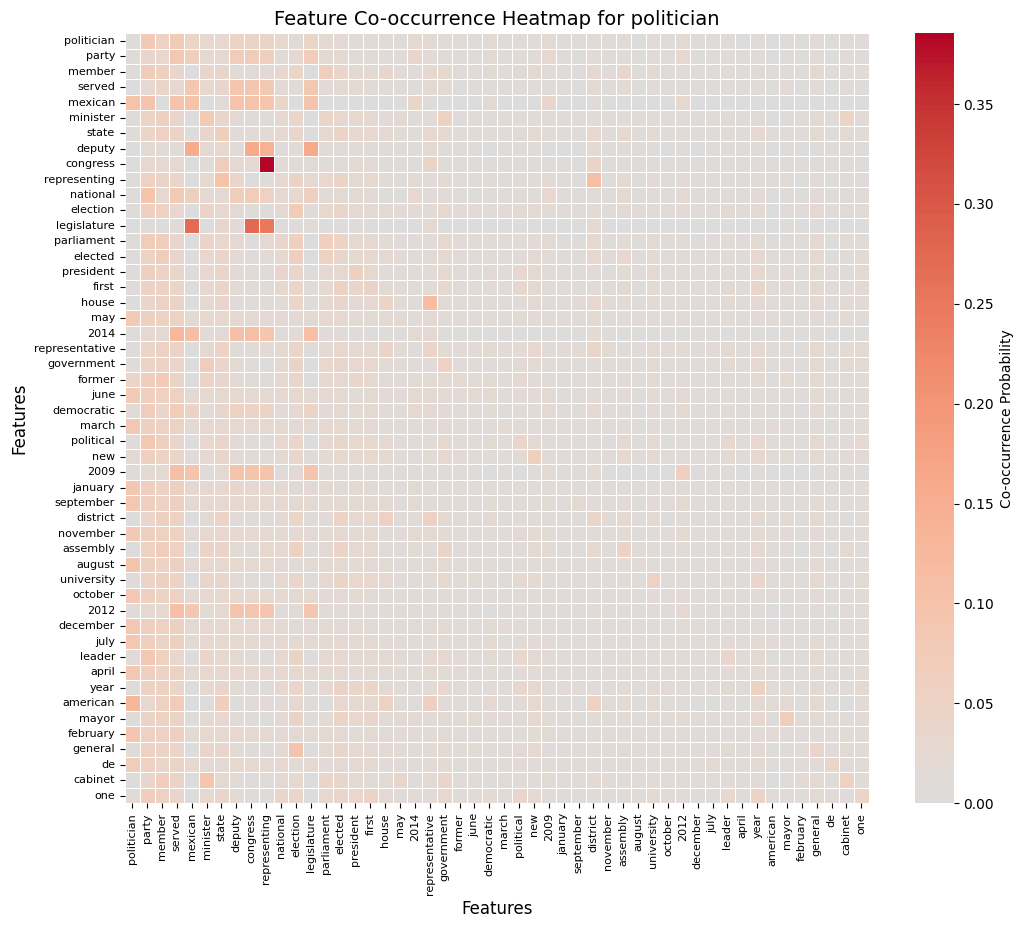

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(data, occupation):
    # Unpack the data
    features = data['features']
    matrix = data['matrix']

    # Create a heatmap using seaborn
    plt.figure(figsize=(12, 10))  # Increase figure size for better readability
    sns.heatmap(matrix, xticklabels=features, yticklabels=features, 
                cmap='coolwarm', center=0, linewidths=0.5, cbar_kws={'label': 'Co-occurrence Probability'})

    plt.title(f'Feature Co-occurrence Heatmap for {occupation}', fontsize=14)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.show()

# Example usage
occupation = 'politician'
data_for_occupation = all_matrices[occupation] 
plot_heatmap(data_for_occupation, occupation)


In [ ]:
# import utils
# print(dir(utils))  


['Counter', 'WordNetLemmatizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'build_probability_matrix_from_list', 'defaultdict', 'get_feature_probabilities', 'json', 'nltk', 'np', 'os', 'preprocess_text', 'save_outputs', 'save_sorted_probabilities', 'stopwords', 'tqdm', 'word_tokenize']


In [33]:
all_matrices["politician"]["matrix"].sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])